# Meta Learning Tutorial with the Omniglot Dataset

In [37]:
import functools

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

import haiku as hk

from tensorflow_probability.substrates import jax as tfp

import omniglot_dataset
import maml
import nets

tfd = tfp.distributions

## Explore the Omniglot dataset a bit

Plotting and exploration based on https://github.com/LecJackS/CS-330-Deep-Multi-Task-and-Meta-Learning/blob/master/hw1/%5BOLD%5DHomework%201%20-%20Step%20by%20step.ipynb

In [38]:
num_classes = 2
num_samples_per_class = 3
meta_batch_size = 32
omniglot = omniglot_dataset.Omniglot(meta_batch_size, num_classes, num_samples_per_class)

support, query = next(omniglot.train_set)

In [39]:
def plot_example(images, labels):
    images = images.reshape((meta_batch_size, -1, num_classes) + images.shape[2:])
    labels = labels.reshape((meta_batch_size, -1, num_classes) + labels.shape[2:])
    plt.figure(figsize=(16, 10))
    count = 0
    for cl in range(images.shape[2]):
        for sa in range(images.shape[1]):
            plt.subplot(num_samples_per_class, num_classes, count + 1)
            plt.title("Class {}\nExample {}\nLabel {}".format(cl, sa, labels[0, sa, cl]))
            image = images[0, sa, cl]
            plt.imshow(image, cmap='Greys')
            plt.axis('off');
            count += 1

Plot of an example support set

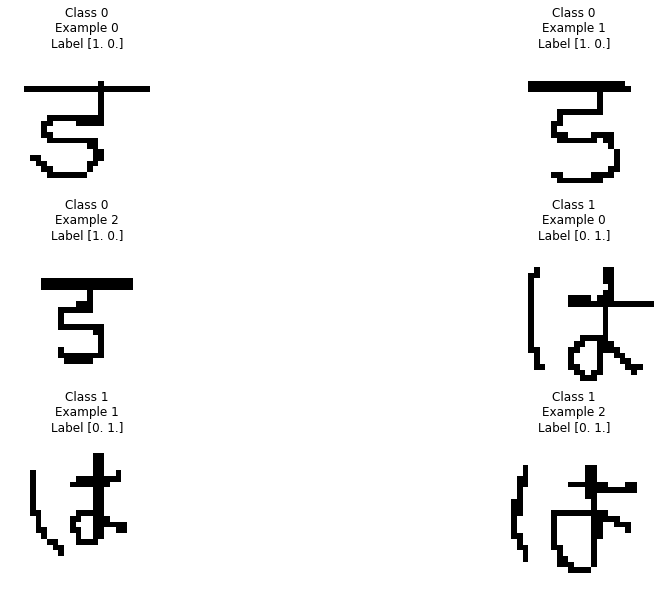

In [40]:
plot_example(*support)

Plot it's corresponding query set

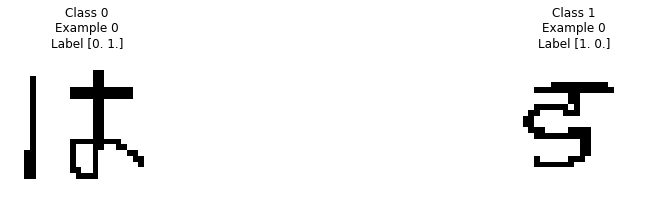

In [41]:
plot_example(*query)

Seems like the query and support sets labels match so everything is good with the data generator!

## Defining a training loop

In [42]:
@functools.partial(jax.jit, static_argnums=[0, 1])
def update(model, opt, prior_params, opt_state, support, query):
    grads = model.update_step(prior_params, support, query)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(prior_params, updates)
    return new_params, new_opt_state

def predict_eval(model, params, x, y):
    dist = model(params, x)
    return dist.mode(), dist.log_prob(y)

predict_eval = jax.vmap(predict_eval, in_axes=[None, 0, 0, 0])
    

def train(model, data, lr=0.001, steps=1000):
    eval_losses = []
    opt = optax.flatten(optax.adam(lr))
    opt_state = opt.init(model.prior_params)
    for step in range(steps):
        model.prior_params, opt_state = update(model, opt, model.prior_params, opt_state, *next(data.train_set))
        if step % 100 == 0:
            eval_support, eval_query = next(data.eval_set)
            posterior_params = model.adaptation_step(model.prior_params, *eval_support)
            pred, eval_ = predict_eval(model, posterior_params, *eval_query)
            eval_loss = -eval_.mean()
            eval_accuracy = (pred == eval_query[1]).mean()
            eval_losses.append(eval_loss)
            print('Training step: {} -- loss: {:.4f} -- accuracy: {:.4f}'.format(step, eval_loss, eval_accuracy))
    return eval_losses
            


## Train MAML

In [43]:
def net(x):
    x = nets.cnn(x, depth=16, kernels=(4, 4))
    x = hk.Flatten()(x)
    logits = hk.Linear(num_classes)(x)
    return tfd.OneHotCategorical(logits)


model = maml.Maml(net, support[0][0], 0.1, adaptation_steps=1)
train(model, omniglot, 1e-2, steps=500)

Training step: 0 -- loss: 0.6507 -- accuracy: 0.6250
Training step: 100 -- loss: 0.4537 -- accuracy: 0.7969
Training step: 200 -- loss: 0.4207 -- accuracy: 0.8281
Training step: 300 -- loss: 0.4598 -- accuracy: 0.8281
Training step: 400 -- loss: 0.3912 -- accuracy: 0.8438


[DeviceArray(0.6507425, dtype=float32),
 DeviceArray(0.4537187, dtype=float32),
 DeviceArray(0.4206672, dtype=float32),
 DeviceArray(0.45981544, dtype=float32),
 DeviceArray(0.3912461, dtype=float32)]